In [4]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.optimizers import SGD
from keras.utils import plot_model
from keras.initializers import RandomNormal
from matplotlib import pyplot

WTInit = RandomNormal(mean=0.0, stddev=0.01, seed=5)
model=Sequential()
model.add(Convolution2D(16, (5, 5), input_shape=(64, 64, 6), activation="relu", kernel_initializer=WTInit, bias_initializer="zeros"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (5, 5), activation="relu", kernel_initializer=WTInit, bias_initializer="zeros"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (5, 5), activation="relu", kernel_initializer=WTInit, bias_initializer="zeros"))

model.add(Flatten())

model.add(Dense(640, activation="relu", kernel_initializer=WTInit, bias_initializer="zeros"))
model.add(Dense(2, activation="softmax", kernel_initializer=WTInit, bias_initializer="zeros"))

sgd = SGD(lr= 0.01, momentum=0.9, decay=0.005)
model.compile(optimizer=sgd, loss="categorical_crossentropy")
print(model.summary())
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 60, 60, 16)        2416      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 64)        25664     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 9, 9, 128)         204928    
_________________________________________________________________
flatten_4 (Flatten)          (None, 10368)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 640)               6636160   
__________

In [27]:
import numpy as np
import imageio
import scipy.io
import pandas as pd

#def LoadData(DS='KinFaceW-I'):
#mat_fd = scipy.io.loadmat(DS + '/fd_pairs.mat')
#s = DS + '/images/'+ string[m]
#s =  '/images/'+ string[m]
def LoadData():
	count=0
	all_images=[]
	Kin = pd.DataFrame(columns=['Fold', 'Kin/Not-Kin'])

	mat_fd = scipy.io.loadmat( 'fd_pairs.mat')
	mat_fd = mat_fd["pairs"]
	mat_fs = scipy.io.loadmat('fs_pairs.mat')
	mat_fs = mat_fs["pairs"]
	mat_md = scipy.io.loadmat('md_pairs.mat')
	mat_md = mat_md["pairs"]
	mat_ms = scipy.io.loadmat('ms_pairs.mat')
	mat_ms = mat_ms["pairs"]

	Mat = [mat_fd, mat_fs, mat_md, mat_ms]
	string = ['father-dau/fd_', 'father-son/fs_', 'mother-dau/md_', 'mother-son/ms_']

	for m in range(0, 4):
		for j in range(0, Mat[m].shape[0]):
			s =  string[m]
			addr = s + Mat[m][j][2][0][3:6]
			image1 = imageio.imread(addr +'_1.jpg')	
			addr = s + Mat[m][j][3][0][3:6]  
			image2 = imageio.imread(addr +'_2.jpg')
			Kin.loc[count] = [Mat[m][j][0][0][0], Mat[m][j][1][0][0]]
			new_image = np.concatenate((image1, image2), axis=2)
			all_images+=[np.array(new_image)]
			count+=1
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
	all_images = np.array(all_images)
	all_images = all_images.astype('float32')
	all_images -= np.mean(all_images, axis=0)
	all_images /= np.std(all_images, axis=0)
	Kin = np.array(Kin)
	Data = [all_images, Kin]

	rng_state = np.random.get_state()
	np.random.shuffle(all_images)
	np.random.set_state(rng_state)
	np.random.shuffle(Kin) 

	Folds = [[[], []], [[], []], [[], []], [[], []], [[], []]]
	for i in range (0, all_images.shape[0]):
		for j in range(0, 5):
			if(Data[1][i][0]==j+1):
				Folds[j] = np.append(Folds[j], [[np.array(all_images[i])], [np.array(Kin[i])]], axis=1)

	X=[[], [], [], [], []]
	Y=[[], [], [], [], []] 
	for i in range(0, 5): 
		X[i] = np.array(Folds[i][0])
		Y[i] = np.array([Folds[i][1][j][1] for j in range(Folds[i].shape[1])]) 

	X_Train=[[], [], [], [], []] 
	Y_Train=[[], [], [], [], []]    
	X_Test=[[], [], [], [], []]
	Y_Test=[[], [], [], [], []]    
    
	for i in range(0, 5):    
		X_Train[i] = np.append(X[i%5], X[(i+1)%5], axis=0)
		X_Train[i] = np.append(X_Train[i], X[(i+2)%5], axis=0)
		X_Train[i] = np.append(X_Train[i], X[(i+3)%5], axis=0)
		Y_Train[i] = np.append(Y[i%5], Y[(i+1)%5], axis=0)
		Y_Train[i] = np.append(Y_Train[i], Y[(i+2)%5], axis=0)
		Y_Train[i] = np.append(Y_Train[i], Y[(i+3)%5], axis=0)
		X_Test[i] = X[(i+4)%5]
		Y_Test[i] = Y[(i+4)%5]
    
	return X_Train, Y_Train, X_Test, Y_Test	

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.optimizers import SGD
from keras.initializers import RandomNormal
from keras.layers import BatchNormalization

def CompileModel():
	model=Sequential()
	model.add(Convolution2D(16, (5, 5), input_shape=(64, 64, 6)))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	model.add(Convolution2D(64, (5, 5)))
	model.add(BatchNormalization())
	model.add(Activation('relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))

	model.add(Convolution2D(256, (5, 5)))
	model.add(BatchNormalization())
	model.add(Activation('relu'))

	model.add(Flatten())
	model.add(Dropout(0.5))
    
	model.add(Dense(640))
	model.add(BatchNormalization())
	model.add(Activation('relu'))

	model.add(Dropout(0.5))
	model.add(Dense(2))
	model.add(Activation('softmax'))

	sgd = SGD(lr=0.0001, momentum=0.9, decay=0.005)
	model.compile(optimizer='sgd', loss="categorical_crossentropy", metrics=['accuracy'])
	print(model.summary())
	return model

In [17]:
import numpy as np
import keras
import sys

sys.path.append('/home/inertfluid/.config/spyder-py3/')

#from DataPreProcess import LoadData
#from ModelCompiler import CompileModel

DataSet = 'KinFaceW-I'
model = CompileModel()
X_Train, Y_Train, X_Test, Y_Test = LoadData()

score=[]
for j in range(0, 5):
    X_Train[j] = np.reshape(list(X_Train[j]), (X_Train[j].shape[0], 64, 64, 6))
    Y_Train[j] = keras.utils.to_categorical(Y_Train[j], 2)
    X_Test[j] = np.reshape(list(X_Test[j]), (X_Test[j].shape[0], 64, 64, 6))
    Y_Test[j] = keras.utils.to_categorical(Y_Test[j], 2)
    model.fit(X_Train[j], Y_Train[j], batch_size=64, epochs=50, validation_data=(X_Test[j], Y_Test[j]), shuffle=True)
    score+=[model.evaluate(X_Test[j], Y_Test[j], verbose=1)]
    
score=np.array(score)
loss = np.average(score.T[0])
accuracy = np.average(score.T[1])

print('Loss:', loss)
print('Accuracy:', accuracy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 60, 60, 16)        2416      
_________________________________________________________________
batch_normalization_25 (Batc (None, 60, 60, 16)        64        
_________________________________________________________________
activation_31 (Activation)   (None, 60, 60, 16)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 30, 30, 16)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 26, 26, 64)        25664     
_________________________________________________________________
batch_normalization_26 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
activation_32 (Activation)   (None, 26, 26, 64)        0         
__________

212/212 [==============================] - 6s 28ms/step
Train on 854 samples, validate on 212 samples
Epoch 1/50
854/854 [==============================] - 59s 70ms/step - loss: 0.0616 - acc: 0.9731 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 2/50
854/854 [==============================] - 59s 70ms/step - loss: 0.0477 - acc: 0.9836 - val_loss: 0.0078 - val_acc: 1.0000
Epoch 3/50
854/854 [==============================] - 61s 72ms/step - loss: 0.0379 - acc: 0.9918 - val_loss: 0.0045 - val_acc: 1.0000
Epoch 4/50
854/854 [==============================] - 58s 68ms/step - loss: 0.0424 - acc: 0.9918 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 5/50
854/854 [==============================] - 63s 73ms/step - loss: 0.0312 - acc: 0.9918 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 6/50
854/854 [==============================] - 62s 72ms/step - loss: 0.0585 - acc: 0.9754 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 7/50
854/854 [==============================] - 57s 67ms/step - loss: 0.0333 - acc: 0.99

Epoch 18/50
854/854 [==============================] - 61s 72ms/step - loss: 0.0051 - acc: 0.9988 - val_loss: 2.9237e-04 - val_acc: 1.0000
Epoch 19/50
854/854 [==============================] - 59s 69ms/step - loss: 0.0051 - acc: 1.0000 - val_loss: 2.3048e-04 - val_acc: 1.0000
Epoch 20/50
854/854 [==============================] - 59s 69ms/step - loss: 0.0045 - acc: 1.0000 - val_loss: 1.7905e-04 - val_acc: 1.0000
Epoch 21/50
854/854 [==============================] - 59s 69ms/step - loss: 0.0049 - acc: 0.9988 - val_loss: 1.5425e-04 - val_acc: 1.0000
Epoch 22/50
854/854 [==============================] - 58s 68ms/step - loss: 0.0069 - acc: 0.9988 - val_loss: 2.2884e-04 - val_acc: 1.0000
Epoch 23/50
854/854 [==============================] - 59s 69ms/step - loss: 0.0080 - acc: 0.9988 - val_loss: 1.5528e-04 - val_acc: 1.0000
Epoch 24/50
854/854 [==============================] - 59s 69ms/step - loss: 0.0048 - acc: 0.9988 - val_loss: 1.7890e-04 - val_acc: 1.0000
Epoch 25/50
854/854 [======

In [18]:
score

array([[7.19048262e-01, 7.47706423e-01],
       [3.67316140e-02, 9.90566037e-01],
       [1.90681015e-03, 1.00000000e+00],
       [5.15741275e-04, 1.00000000e+00],
       [2.02133383e-04, 1.00000000e+00]])

AxesImage(54,36;334.8x217.44)


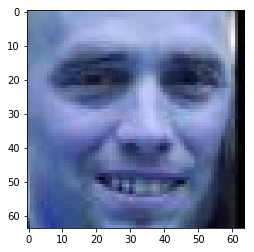

In [30]:
import cv2
from matplotlib import pyplot as plt
image1=cv2.imread("fd_001_1.jpg")
image2=cv2.imread("fd_001_2.jpg")
father = np.concatenate((image1, image2), axis=2)
print(plt.imshow(image1))

#father.shape


AxesImage(54,36;334.8x217.44)


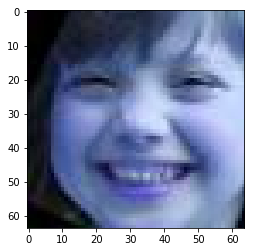

In [29]:
print(plt.imshow(image2))

In [43]:
import scipy.io
mat_fd = scipy.io.loadmat( 'fd_pairs.mat')
print(mat_fd["pairs"][:5,:])

[[array([[1]], dtype=uint8) array([[1]], dtype=uint8)
  array(['fd_024_1.jpg'], dtype='<U12')
  array(['fd_024_2.jpg'], dtype='<U12')]
 [array([[1]], dtype=uint8) array([[1]], dtype=uint8)
  array(['fd_092_1.jpg'], dtype='<U12')
  array(['fd_092_2.jpg'], dtype='<U12')]
 [array([[1]], dtype=uint8) array([[1]], dtype=uint8)
  array(['fd_124_1.jpg'], dtype='<U12')
  array(['fd_124_2.jpg'], dtype='<U12')]
 [array([[1]], dtype=uint8) array([[1]], dtype=uint8)
  array(['fd_031_1.jpg'], dtype='<U12')
  array(['fd_031_2.jpg'], dtype='<U12')]
 [array([[1]], dtype=uint8) array([[1]], dtype=uint8)
  array(['fd_008_1.jpg'], dtype='<U12')
  array(['fd_008_2.jpg'], dtype='<U12')]]


In [37]:
import numpy as np
father_batch=np.expand_dims(father,axis=0)
father_conv=model.predict(father_batch)
print(father_conv)
#def visualise(father_batch):
#    father=np.squeeze(father_batch,axis=0)
#    plt.imshow(father)
#visualise(father_conv)

[[0.51766187 0.48233816]]
